Name : Gheddi 
Batch : RMT - 022
Objective : this program does web scraping on Tokopedia website and perform statistic from the result

A. Web Scraping

In [96]:
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import numpy as np
import time

driver = webdriver.Chrome()

name = []
price = []
location = []
shop = []
rating = []
amount = []
# <span class='prd_link-shop-name css-1kdc32b flip'>

for i in range(1,11):
    driver.get('https://www.tokopedia.com/search?navsource=&page={}&q=seblak&srp_component_id=02.01.00.00&srp_page_id=&srp_page_title=&st='.format(i))
    time.sleep(5)
    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")

    # product section contains 5-10 product card
    # product labels, contains only name, price, rating, etc

    for sections in soup.find_all('div',class_ ="css-jza1fo"):
        
        for labels in sections.find_all('a', class_='pcv3__info-content css-gwkf0u'):
            name.append(labels.find('div', class_='prd_link-product-name css-3um8ox').get_text())
            price.append(labels.find('div', class_='prd_link-product-price css-1ksb19c').get_text())

            if labels.find('span', class_ = 'prd_link-shop-loc css-1kdc32b flip'):
                location.append(labels.find('span', class_ = 'prd_link-shop-loc css-1kdc32b flip').get_text())
            else:
                location.append(np.nan)

            if labels.find('span', class_ = 'prd_link-shop-loc css-1kdc32b flip'):
                shop.append(labels.find('span', class_ = 'prd_link-shop-name css-1kdc32b flip').get_text())
            else:
                shop.append(np.nan)

            if labels.find('span', class_ = 'prd_rating-average-text css-t70v7i'):
                rating.append(labels.find('span', class_ = 'prd_rating-average-text css-t70v7i').get_text())
            else:
                rating.append(np.nan)

            if labels.find('span', class_ = 'prd_label-integrity css-1duhs3e'):
                amount.append(labels.find('span', class_ = 'prd_label-integrity css-1duhs3e').get_text())
            else:
                amount.append(np.nan)

df = pd.DataFrame()
df['Product Name'] = name
df['Price'] = price
df['Shop Location'] = location
df['Shop Name'] = shop
df['Product Rating'] = rating
df['Amount Sold'] = amount        

B. Data Preparation

In [143]:
# data exploration
df.sample(4)

,Product Name,Price,Shop Location,Shop Name,Product Rating,Amount Sold
162,U Mart - Kerupuk Merah Gado Gado/Bubur Ayam 1 ...,19000,Jakarta Selatan,U Mart Indonesia,4.9,70
333,Seblak Mercon Khas Tasik 150gr Pedas Jelotot,9000,Tangerang,Al Dien Store 313,4.8,50
483,Sukro pilus Cikur Sari rasa 1 renceng 10bks - ...,6000,Kab. Bekasi,Distributor Cuanki dan Seblak,4.5,70
53,Kerupuk Seblak Mentah/ Krupuk Seblak Viral/ Ke...,112000,Jakarta Pusat,Makanan Tradisi Id,5.0,11


In [98]:
# check for the amount of missing value
df.isna().sum()

Product Name       0
Price              0
Shop Location      0
Shop Name          0
Product Rating    45
Amount Sold       36
dtype: int64

In [99]:
# DATA PREPROCESSING

# remove missing value
df.dropna(subset = ['Shop Location', 'Shop Name', 'Product Rating', 'Amount Sold'], inplace=True)

# convert price column to integer
remove_symbol = lambda x: (x.replace('Rp', ''))
remove_dot = lambda x: (x.replace('.', ''))

df['Price'] = df['Price'].apply(remove_symbol)
df['Price'] = df['Price'].apply(remove_dot)
df['Price'] = df['Price'].astype(int)

# convert product rating to float
df['Product Rating'] = df['Product Rating'].astype(float)

# convert amount sold column to integer
remove_terjual = lambda x: (x.replace('Terjual', ''))
remove_space = lambda x: (x.replace(' ', ''))
remove_plus = lambda x: (x.replace('+', ''))
alter_rb = lambda x: (x.replace('rb', '000'))
df['Amount Sold'] = df['Amount Sold'].apply(remove_terjual)
df['Amount Sold'] = df['Amount Sold'].apply(alter_rb)
df['Amount Sold'] = df['Amount Sold'].apply(remove_plus)
df['Amount Sold'] = df['Amount Sold'].apply(remove_space)
df['Amount Sold'] = df['Amount Sold'].astype(int)

C. Business Understanding

Specific --> Increase the number of customer based on better price offering

Measurable --> increase order by 200 item monthly with better price

Achievable --> the means of finding better price is achievable through statistical method

Relevant --> With better price offering will attract more customer

Time-bound --> Researching for better price should take less than a month

D. Analysis

<Axes: >

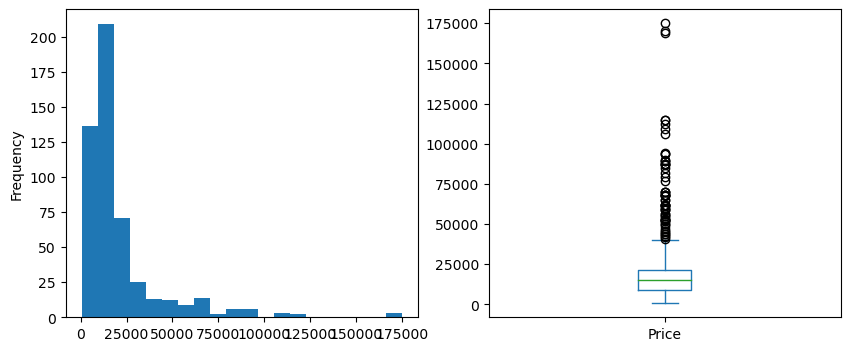

In [110]:
# Question 1
# mean, median, std, skew, kurtosis of price column
# describe outlier in price column if exist

df['Price'].info()
df['Price'].std()
df['Price'].skew()
df['Price'].kurtosis()

# displaying outlier with box-plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2,figsize=(10,4))

df['Price'].plot(kind='hist',bins=20,ax=ax[0])
df['Price'].plot(kind='box',ax=ax[1])

<Axes: >

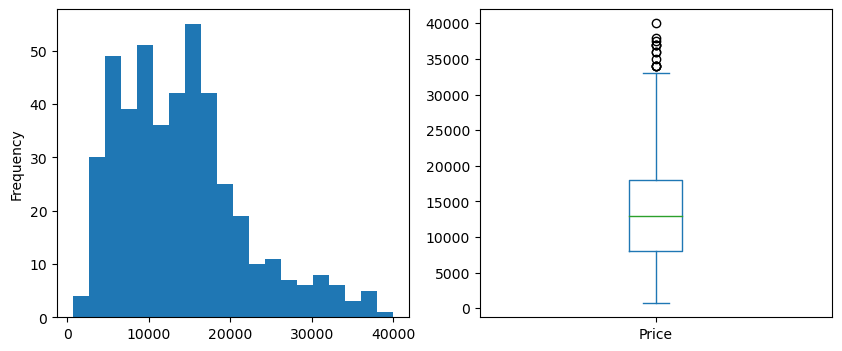

In [112]:
# defining the interquartile range
q1 = df['Price'].quantile(0.25)
q3 = df['Price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Membuat dataframe baru yang tidak memiliki outlier
df_filtered = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

# displaying new dataframe without outlier
fig, ax = plt.subplots(ncols=2,figsize=(10,4))

df_filtered['Price'].plot(kind='hist',bins=20,ax=ax[0])
df_filtered['Price'].plot(kind='box',ax=ax[1])

In [125]:
# Question 2
# whats the earning potential of selling seblak? use the price and amount column

import numpy as np
import scipy.stats as st

# Calculate confidence Intervals using the Normal Distribution
# This approach is used to calculate confidence Intervals for the large dataset where the sample size > 30

lower_price, higher_price =st.norm.interval(0.95, loc=np.mean(df_filtered['Price']), scale=st.sem(df_filtered['Price']))
mean_amt_sold = df_filtered['Amount Sold'].mean()  # 346.15  #df_filtered['Amount Sold'].mean()  # 346.15  
expected_minimum_earning = lower_price * mean_amt_sold
expected_maximum_earning = higher_price * mean_amt_sold

# print out the expected minimum and maximum earning
print(expected_minimum_earning, expected_maximum_earning)
            

4607288.66531165 5102294.159783461


In [ ]:
# Question 3
# with confidence interval >=95%, 
# perform hypothesis testing to check whether the prices within jabodetabek are different from 
# outside jabodetabek
# h0 price is not different
# toko jabodetabek is group A, outside is group B. 

In [141]:
# Question 4
# do people like to purchase cheaper product?
# Answer with correlation test
# find median, group the price to 2 category where median is the middle price
# find the 2 group relation with amount sold
# get correlation value and its p-value

from scipy import stats

df_filtered['Price'].median() # median of price column is Rp. 13.000

def grouper(row):
    if row['Price'] <= 13000:
        val = 'CHEAP'
    else:
        val = 'EXPENSIVE'
    return val

df_filtered['Price Category'] = df_filtered.apply(grouper, axis=1)

cheap = df_filtered['Amount Sold'][df_filtered['Price Category']=='CHEAP']
expensive = df_filtered['Amount Sold'][df_filtered['Price Category']=='EXPENSIVE']
res = stats.f_oneway(cheap, expensive)
print('P-value:',res.pvalue)
# with P-value is as big as 89% our null hypothesis is not rejected 
# therefore cheap product doesnt entice customer

P-value: 0.8999058501582072


/var/folders/7d/xp2y06297y75ft442v1cl8dc0000gn/T/ipykernel_2939/680140332.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Price Category'] = df_filtered.apply(grouper, axis=1)
